# A Recurrent Network Mechanism of Time Integration in Perceptual Decisions
Wong,  Wang
Journal of Neuroscience, January 2006, 26(4):1212-1328

## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

In [2]:
def H(x):
    a=207
    b=108
    d=0.154
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f


### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2




### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [4]:
def Background_Activity(I_noise,h):
    
    sigma_noise=0.02 # nA
    tau_AMPA=2#ms
    eta_noise=np.random.normal(0,1,(1,N))
    I_0=0.0#3255  # nA
    I_noise_new=I_noise+(h)/tau_AMPA*(-(I_noise-I_0)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [5]:
#def Network_Dynamics(S,x):
#    h=0.1/1000 #ms
#    gamma=0.641
#    tau_S=.100 #s
#    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
#    S_new=S+h*k#(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
#    return S_new

def Network_Dynamics(S,x,h):
    h1=h/1000
    tau_S=100/1000#100 #ms
    𝛾=0.641
    S_new=S+h1*((-S/tau_S)+(1-S)*𝛾*H(x))
    return S_new

### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/1000# nA/Hz
    mu_0=30 # Hz
    f=1.0
    p=0
    I_motion=J_A_ext*mu_0*(1+f*(c_dash+p)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=5.2/1000# nA/Hz
    mu_0=30 # Hz
    f=1.0
    p=0
    I_motion=J_A_ext*mu_0*(1+f*(-c_dash+p)/100)
    return I_motion

In [18]:
h=0.1
time=np.arange(-300,2000,h)
J_A_ext=5.2/1000 # nA/Hz
mu_0=30 # Hz
Vector_coherence=[2,5,10,15]


Threshold=15
N=1000
RT_coh_hit=np.zeros(len(Vector_coherence))
RT_coh_miss=np.zeros(len(Vector_coherence))
Prob=np.zeros(len(Vector_coherence))
count=0
#fig = plt.figure(figsize=(12,8))

ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_1=0.0*np.ones((N,len(time))) # np.zeros((1,len(time)))
I_2=0.0*np.ones((N,len(time))) # np.zeros((1,len(time)))
Firing_target_1=5*np.ones((N,len(time))) # np.zeros((1,len(time)))
Firing_target_2=5*np.ones((N,len(time))) # np.zeros((1,len(time)))

In [19]:
for j in range(0,len(Vector_coherence)):
    print("Coherence:", Vector_coherence[j])
    ANSWER=np.zeros(N)
    RT=np.zeros(N)
    count=np.zeros(N)

    x_1=J_A_ext*mu_0*np.random.uniform(0,1,(N,len(time)))
    x_2=J_A_ext*mu_0*np.random.uniform(0,1,(N,len(time)))

    S=0.5
    S_1=S+np.random.normal(0,0.01,(N,len(time)))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
    S_2=S+np.random.normal(0,0.01,(N,len(time))) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

    I_noise_1=0.004*np.random.uniform(0,1,(N,len(time)))   # initalise noisy input as normal distribution
    I_noise_2=0.004*np.random.uniform(0,1,(N,len(time)))   # why multiply by 0.004? Or how to know to do this  ?

    Firing_target_1[:,0]=H(x_1[:,0])
    Firing_target_2[:,0]=H(x_2[:,0])


 #   count=0
    for i in range (0,len(time)-1):
        
        if time[i] >=0 and time[i]<1000:
            c_dash=Vector_coherence[j]
        else:
            c_dash=0.0


        I_noise_1[:,i+1]=Background_Activity(I_noise_1[:,i],h)
        I_noise_2[:,i+1]=Background_Activity(I_noise_2[:,i],h)

        I_1[:,i+1]=I_input_1(c_dash)
        I_2[:,i+1]=I_input_2(c_dash)

        S_1[:,i+1]=Network_Dynamics(S_1[:,i],x_1[:,i],h)
        S_2[:,i+1]=Network_Dynamics(S_2[:,i],x_2[:,i],h)
        x_1[:,i+1],x_2[:,i+1]=total_synaptic_current(S_1[:,i+1],S_2[:,i+1],I_1[:,i+1],
                                                     I_2[:,i+1],I_noise_1[:,i+1],I_noise_2[:,i+1])

        Firing_target_1[:,i+1]=H(S_1[:,i+1])
        Firing_target_2[:,i+1]=H(S_2[:,i+1])

        if time[i] >=0:
            RT[(np.abs(Firing_target_1[:,i+1]-Firing_target_2[:,i+1])>15) & (count==0)]=time[i]
       
            ANSWER[(Firing_target_1[:,i+1]>15)]=1
            count[(np.abs(Firing_target_1[:,i+1]-Firing_target_2[:,i+1])>15) ]=1
   
     
    RT_coh_hit[j]=np.average(RT[ANSWER==1])
    RT_coh_miss[j]=np.average(RT[ANSWER==0])
    Prob[j]=np.average(ANSWER)
    

Coherence: 2
Coherence: 5
Coherence: 10
Coherence: 15


### Plotting
#### Input

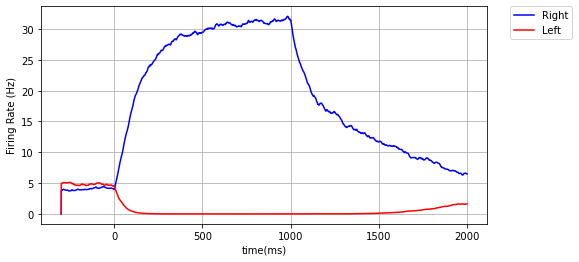

In [20]:
fig = plt.figure(figsize=(8,4))

plt.plot(time,Firing_target_1[1,:],'-',color='blue',label="Right")
plt.plot(time,Firing_target_2[1,:],'-',color='red',label="Left")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
#plt.ylim((0,Threshold*1.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Vector_Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

plt.show()


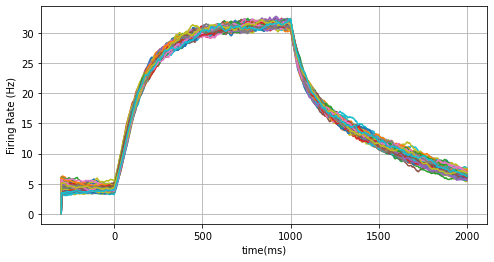

In [21]:
fig = plt.figure(figsize=(8,4))

for j in range(0,100):
    plt.plot(time,Firing_target_1[j,:])

plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
#plt.ylim((0,Threshold*1.5))

plt.savefig('Vector_Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

plt.show()



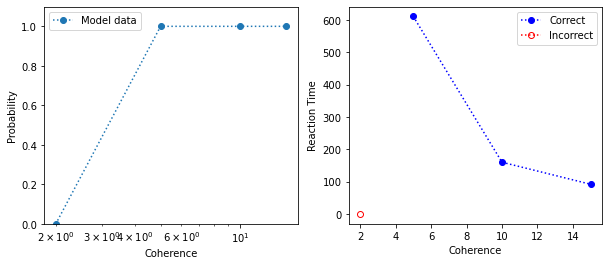

In [12]:
from scipy.optimize import curve_fit
from scipy.stats import norm


def func_temp(coh,alpha,beta):
    return 1-0.5*np.exp(-(coh/alpha)**beta)

Vector_coh=np.array(Vector_coherence)/100.0
#popr, pcov=curve_fit(func_temp,Prob,Vector_coherence)

#mu,sigma=curve_fit(norm.cdf,Vector_coherence,Prob,p0=[0,1])[0]


fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(Vector_coherence,Prob,'o:',label='Model data')
Vector_coh=np.arange(np.min(Vector_coherence),np.max(Vector_coherence),0.01)

#plt.plot(Vector_coh*100,func_temp(Vector_coh,*popr),'k',label='Fit: a= %0.4f, b= %0.4f'% tuple(popr))

#plt.plot(Vector_coh,norm.cdf(Vector_coh,mu,sigma),'k',label='Fit: mu= %2.4f, sigma= %2.4f'% (mu,sigma))
plt.xscale('log')
plt.legend()



plt.xlabel('Coherence')
plt.ylabel('Probability')
#plt.xscale('log')
plt.ylim(0,1.1)
plt.subplot(122)
plt.plot((Vector_coherence),RT_coh_hit,'o:',color='blue',label="Correct")
plt.plot((Vector_coherence),RT_coh_miss,'o:',fillstyle='none',color='red',label="Incorrect")
#plt.xscale('log')
plt.legend()
#plt.ylim(0,1000)
plt.xlabel('Coherence')
plt.ylabel('Reaction Time')
#plt.savefig('Vec_Behavioural.png', bbox_inches='tight',dpi=300)
plt.show()

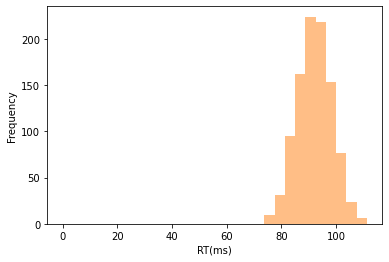

In [13]:
plt.hist(RT[ANSWER==0])
plt.hist(RT[ANSWER==1],alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('RT(ms)')
plt.show()

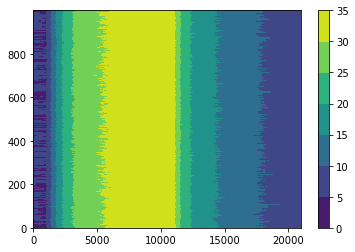

In [14]:
plt.contourf(Firing_target_1)
plt.colorbar()
plt.show()

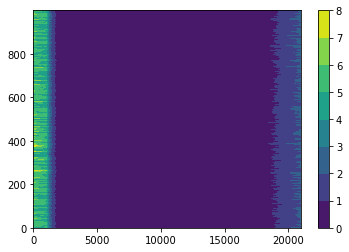

In [15]:
plt.contourf(Firing_target_2)
plt.colorbar()
plt.show()

In [16]:
count

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [17]:
J_A_ext*mu_0

0.156